In [1]:
# 重みを指定
MODEL_NAME = "wl_2layer_20190622_142021.npz"
# 画像(.jpg形式)が入っているフォルダを指定
IMAGES_DIR = "wl_images/sample/"
# 画像フォルダに入っている *_label.pngを読み込み，lossを計算するときはTrueにする
READ_LABEL = False
# GPUを使って処理時間を計測するときは Trueにする
GPU_MODE = False

In [2]:
# model definition and training
import chainer
from PIL import Image
import numpy as np
import argparse
import glob
from time import strftime
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
from chainer.backends import cuda
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from chainer import training
from chainer.training import extensions

class WLClassifier(chainer.Chain):
    def __init__(self, predictor):
        super(WLClassifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, *args):
        x = args[0]
        t = args[-1]
        self.y = None
        self.loss = None
        self.accuracy = None
        self.y = self.predictor(x)
        self.loss = self.lossfun(self.y, t)
        chainer.report({'loss': self.loss}, self)
        #print(np.sqrt(mean_squared_error(t[0][0], self.y.data[0][0])))
        return self.loss
        
    def lossfun(self, y, t):
        return F.sigmoid_cross_entropy(y,t)

class MLP(chainer.Chain):

    def __init__(self, n_units1, n_units2):
        super(MLP, self).__init__()
        with self.init_scope():
            initializer = chainer.initializers.HeNormal()
            self.l1 = L.Convolution2D(3, n_units1, 5, stride=1, pad=2, initialW=initializer)
            #self.l2 = L.Convolution2D(None, n_units2, 5, stride=1, pad=2, initialW=initializer)
            self.l3 = L.Convolution2D(None, 1, 1)
            
    def __call__(self, *args):

        #assert len(args) >= 2
        x = args[0]
        #t = args[-1]
        #t = x
        #self.y = None
        #self.loss = None
        #self.accuracy = None
        self.y = self.forward(x)
        #self.loss = self.lossfun(self.y, t)
        #chainer.report({'loss': self.loss}, self)
        #print(np.sqrt(mean_squared_error(t[0][0], self.y.data[0][0])))
        return self.y
 
    def forward(self, x):
        #print(x.data.shape)
        h1 = F.relu(self.l1(x))
        #h2 = F.relu(self.l2(h1))
        #print(h1.data.shape)
        h3 = self.l3(h1)
        return h3

    def lossfun(self, y, t):
        return F.sigmoid_cross_entropy(y,t)
        #return (y * (t - (y >= 0)) - F.log1p(F.exp(-F.abs(y))))
        #return chainer.functions.mean_squared_error(F.tanh(y), (-t*2+1).astype(np.float32))
        

In [3]:
def eval_image(fname, thre):
    model.to_cpu()
    # 入力画像の読み込み
    testx = np.zeros((0, 3, imh, imw), dtype=np.float32)
    img = Image.open(fname).convert('RGB').resize((imw,imh))
    a = np.asarray(img).transpose(2,0,1).astype(np.float32)/255.
    a1 = np.expand_dims(a,axis=0)
    #print(a1.shape)
    testx = np.append(testx, a1, axis=0)
    
    # ラベル画像の読み込み
    label = np.zeros((0, 1, imh, imw), dtype=np.int32)
    if READ_LABEL:
        lfile = os.path.splitext(fname)[0] + '_label.png'
        limg = Image.open(lfile).resize((imw, imh))
        limg = limg.convert('L')
    else:
        limg = Image.new('L', (imw,imh))
    a = np.asarray(limg).astype(np.float32)/254.
    a = a.astype(np.int32)
    a1 = np.expand_dims(a,axis=0)
    a1 = np.expand_dims(a1,axis=0)
    label = np.append(label, a1, axis=0)

    import time
    t0 = time.time()
    with chainer.using_config('train', False), \
            chainer.using_config('enable_backprop', False):
        testy = model.forward(testx)
        loss = model.lossfun(testy,label)
        #print('y',testy.shape)
        #print('t',label.shape)
    
    cols=2
    if READ_LABEL:
        cols=3

    #fig, axs = plt.subplots(1,3)
    #plt.imshow(img, ax=axs[0])
    imd = Image.new('RGB', (imw*cols, imh))
    thimg = (testy.data[0][0]> thre)
    thimg = thimg.astype(np.uint8) * 255
    thimg = Image.fromarray(thimg, 'L')

    fig = plt.figure(figsize=(30,10))
    ax = fig.add_subplot(1,1,1)
    imd.paste(img, (0,0))
    ax.imshow(imd)
    imd.paste(thimg, (imw, 0))
    ax.imshow(imd)
    if READ_LABEL:
        imd.paste(limg, (imw*2, 0))
        ax.imshow(imd)
    plt.show()
    print('file    : ',f)
    if READ_LABEL:
        print('loss    : ',loss)
    print('time [s]: ' + str(time.time()-t0))
    return testy.data[0][0], loss.data


In [4]:
imw = 320
imh = 240

model = MLP(4,2)
#x = np.zeros((0, 3, imh, imw), dtype=np.float32)
#t = np.zeros((0, 1, imh, imw), dtype=np.int32)
classifier = WLClassifier(model)
optimizer = chainer.optimizers.Adam()
optimizer.setup(classifier)
if GPU_MODE:
    np = cuda.cupy()
    model.to_gpu()
chainer.serializers.load_npz(MODEL_NAME,model,)

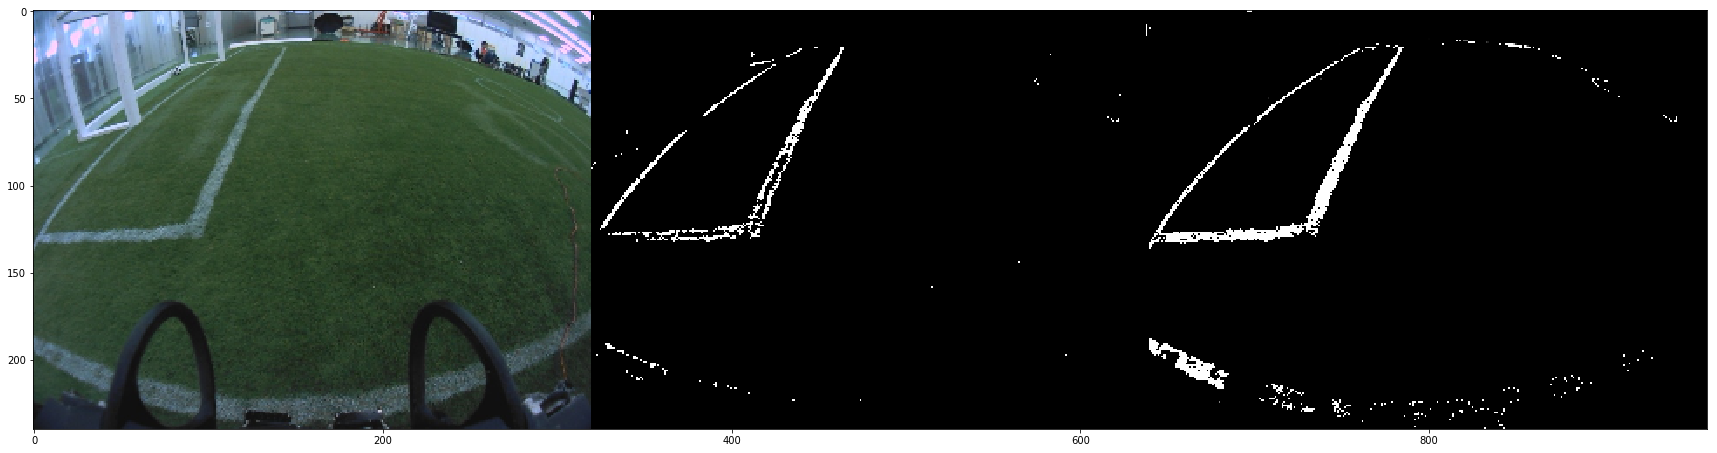

file    :  wl_images/sample/000003.jpg
loss    :  variable(0.03519319)
time [s]: 0.7393147945404053


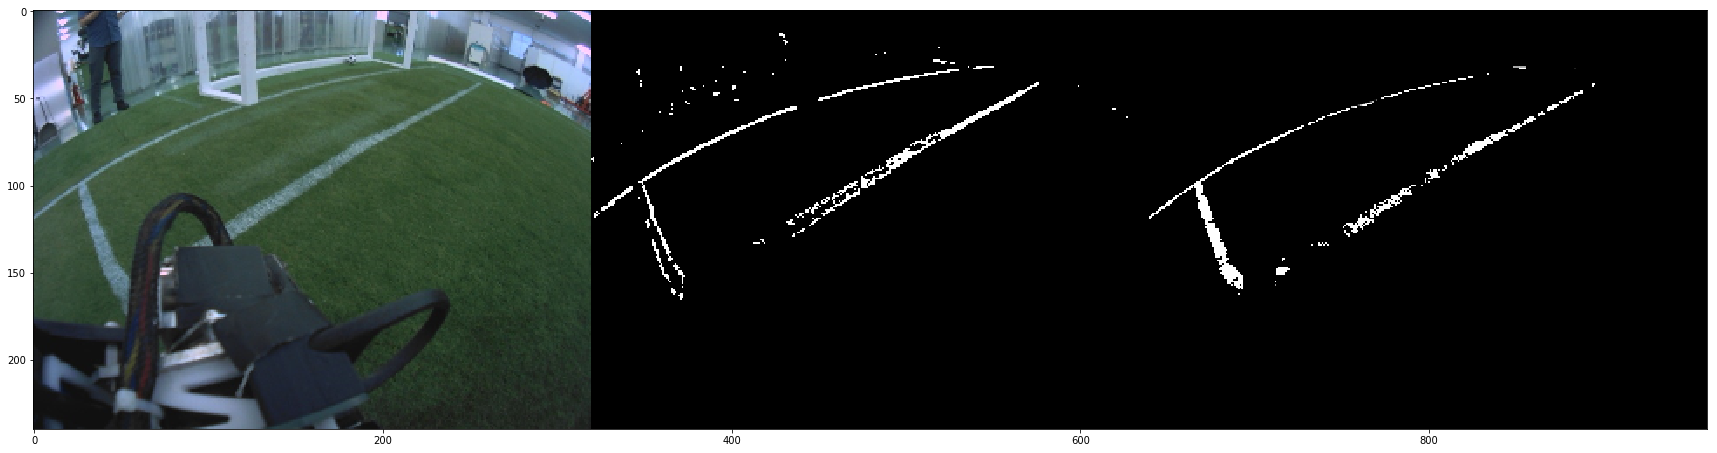

file    :  wl_images/sample/000013.jpg
loss    :  variable(0.04028165)
time [s]: 0.8514542579650879


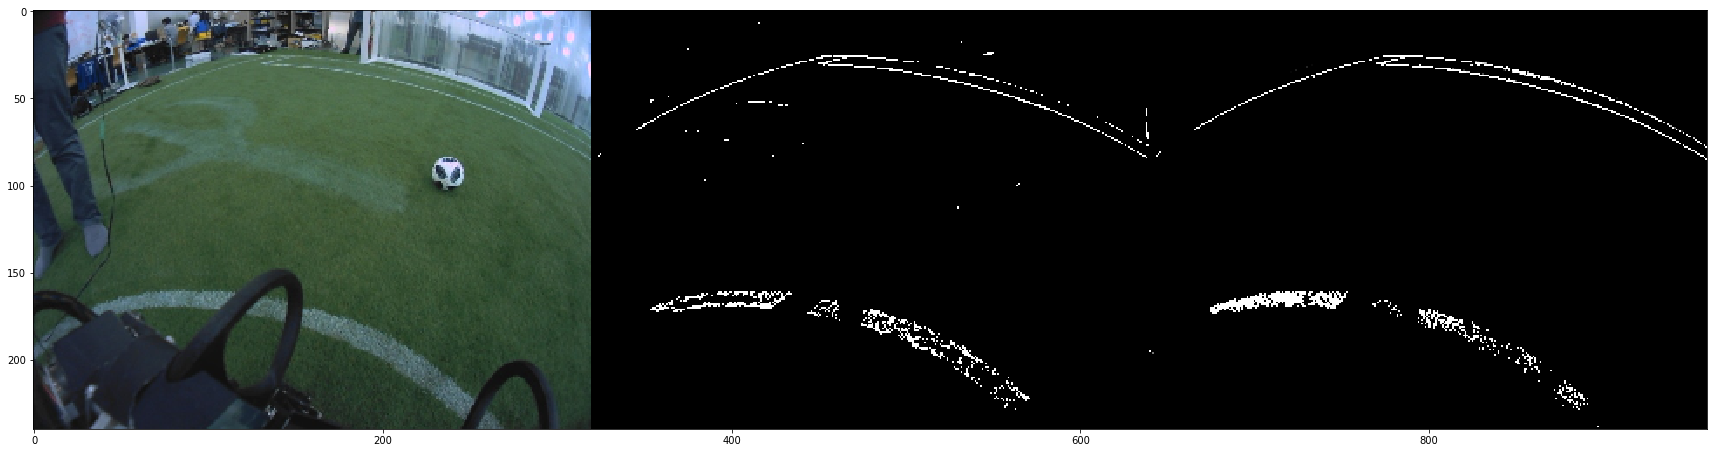

file    :  wl_images/sample/000047.jpg
loss    :  variable(0.02886198)
time [s]: 0.8691732883453369


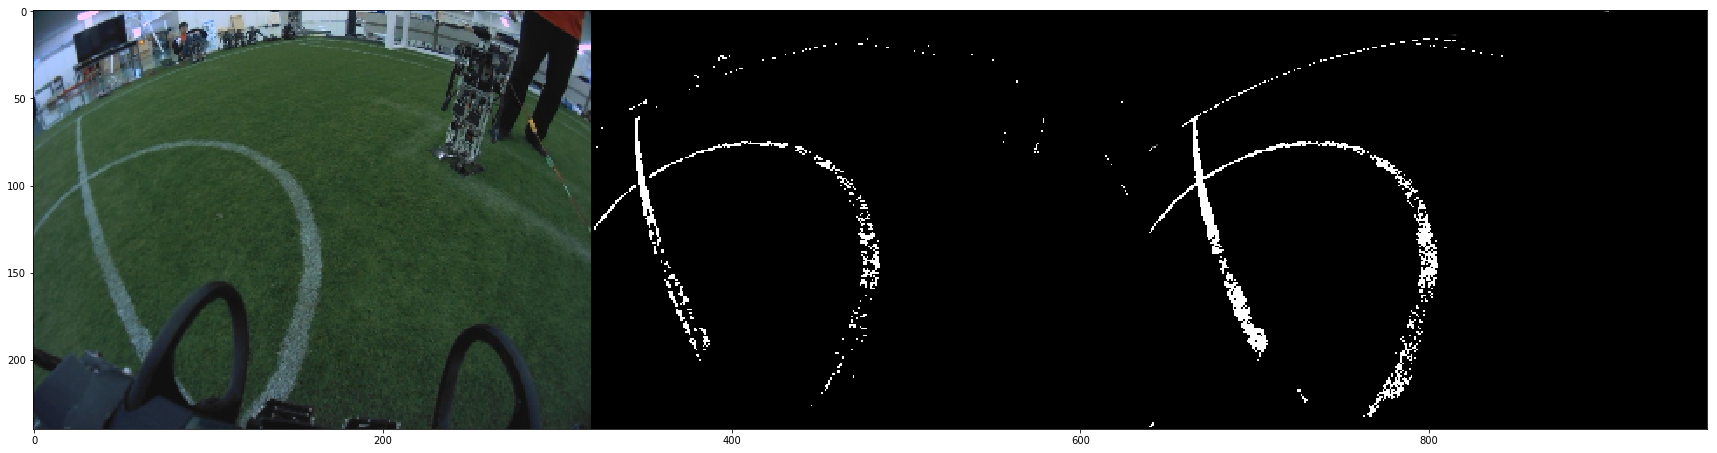

file    :  wl_images/sample/000034.jpg
loss    :  variable(0.02477372)
time [s]: 0.8377234935760498

Result
|- Average loss : 0.032277636


In [7]:
import os
jpgfiles = glob.glob(IMAGES_DIR+'/*.jpg')
#print(jpgfiles)
L = []
with chainer.using_config('train', False):
    for f in jpgfiles:
        y,loss = eval_image(f, 0)
        L.append(loss)

if READ_LABEL:
    print('\nResult')
    print('|- Average loss :', np.mean(L))